In [8]:
import pandas as pd
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage import exposure
from astropy import wcs
import warnings
warnings.filterwarnings("ignore")
from astropy.coordinates import angular_separation
import seaborn as sns
import itertools
import astropy.units as u
import astropy.constants as c
import tqdm
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd 

In [2]:
directory = '/Users/mncavieres/Documents/2022-1/Investigacion/Magellanic Stream'
files = os.listdir(directory)
chips = [obs for obs in files if 'v20180602' in  obs]

# Chip by chip

In [5]:
coord = []
for chip in chips:
    hdul = fits.open(f'{directory}/{chip}') #load single fits file

    #p2, p98 = np.percentile(hdul[1].data, (2, 98)) #contrast stretch so that it looks better
    #img_rescale = exposure.rescale_intensity(hdul[1].data, in_range=(p2, p98))
    
    #get chip number, seeing and airmass
    inhdr = hdul[16].header
    alhdr = hdul[0].header
    seeing = inhdr['seeing']
    #print(f'seeing is {seeing}')
    chip_name = inhdr['EXTNAME']
    print(f'chip:{chip_name}')
    
    #airmass = inhdr['']
    #img_adapteq = exposure.equalize_adapthist(hdul[1].data, clip_limit=0.03)
    #plt.imshow(np.sinh(img_rescale), cmap= 'gray')
    #plt.show()
    w = wcs.WCS(hdul[1].header, hdul)
    coordinates = w.wcs_pix2world(0., 0., 1)
    coord.append(coordinates)
coord = np.array(coord)

chip:DET1.CHIP16
chip:DET1.CHIP16
chip:DET1.CHIP16
chip:DET1.CHIP16
chip:DET1.CHIP16


In [5]:
ra = coord.transpose()[0]
dec = coord.transpose()[1]

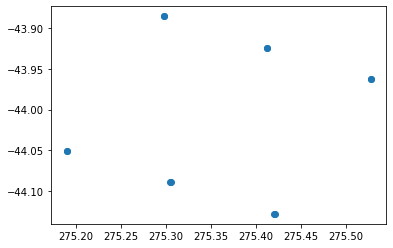

In [6]:
plt.scatter(ra, dec)

In [6]:
w = wcs.WCS(hdul[1].header, hdul)

w.reorient_celestial_first()
cord = w.wcs_pix2world(1., 1., 1)


In [8]:
c = []
for i in range(2108):
    for j in range(2108):
        pix_value = hdul[1].data[j][i]
        cord = w.wcs_pix2world(j, i, 1)
        cord.append(np.array(pix_value))
        c.append(cord)




In [9]:
c = np.array(c)
ra = c.transpose()[0]
dec = c.transpose()[1]
val = c.transpose()[2]

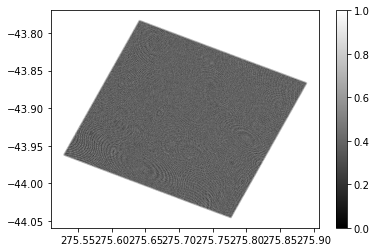

In [10]:
plt.scatter(ra, dec, c = val/max(val), cmap='gray', s = 0.000001)
plt.colorbar()

In [11]:
coordinates = w.wcs_pix2world(0., 0., 1)
print(coordinates)

[array(275.52825018), array(-43.96242612)]


In [ ]:
hdul = fits.open('/Users/mncavieres/Documents/2022-1/Investigacion/Magellanic Stream/v20160714_00313_st.fit') #load single fits file

for i in range(1, 17):
    p2, p98 = np.percentile(hdul[1].data, (2, 98)) #contrast stretch so that it looks better
    img_rescale = exposure.rescale_intensity(hdul[i].data, in_range=(p2, p98))

    inhdr = hdul[i].header
    chip_name = inhdr['EXTNAME']
    print(f'chip:{chip_name}')

    w = wcs.WCS(hdul[i].header, hdul)
    coordinates = w.wcs_pix2world(0., 0., 1)
    print(coordinates)


    #img_adapteq = exposure.equalize_adapthist(hdul[i].data, clip_limit=0.03)
    plt.imshow(np.sinh(img_rescale), cmap= 'gray')  
    plt.show()

# Get pixel to angular length convertion

In [2]:
w = wcs.WCS(hdul[1].header, hdul)

chip_ori = w.wcs_pix2world(0., 0., 1)
chip_end =  w.wcs_pix2world(0., 2108., 1)
ang_dist = angular_separation(chip_ori[0], chip_ori[1], chip_end[0], chip_end[1] ) #angular lenght of an image

def pix_deg(pix):
    return pix*ang_dist/2108

def deg_pix(deg):
    return 2108*deg/ang_dist

#now we need the angular distance between the last pixel of chip1 and then the first pixel of chip2
last_ch1 = np.array(w.wcs_pix2world(2108., 2108., 1))
w2 = wcs.WCS(hdul[2].header, hdul)
first_ch2 = np.array(np.array(w2.wcs_pix2world(0., 2108., 1)))
lat_sep_ang_dist = angular_separation(last_ch1[0], last_ch1[1], first_ch2[0], first_ch2[1] ) #lateral angular separation between chips 

#vertical angular separation between chips
w5 = wcs.WCS(hdul[5].header, hdul)
vert_sep_ang_dist = angular_separation(np.array(w.wcs_pix2world(0., 2108., 1))[0], np.array(w.wcs_pix2world(0., 2108., 1))[1], np.array(w5.wcs_pix2world(0., 0., 1))[0], np.array(w5.wcs_pix2world(0., 0., 1))[1] )


AttributeError: 'WCS' object has no attribute 'WCS'

check chip sky position

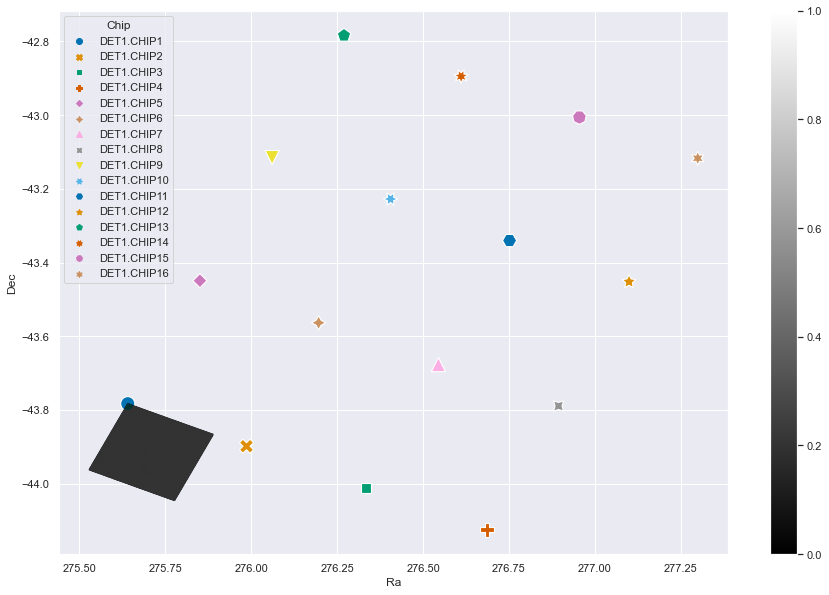

In [26]:
coord = []
chip_name = []
for i in range(1, 17):
    w = wcs.WCS(hdul[i].header, hdul)
    coordinates = w.wcs_pix2world(0., 2108., 1)
    coord.append(coordinates)
    chip_name.append(hdul[i].header['EXTNAME'])
coord = np.array(coord)

df = pd.DataFrame()
df['Ra'] = coord.transpose()[0]
df['Dec'] = coord.transpose()[1]
df['Chip'] = chip_name


#create markers
sns.set(rc={'figure.figsize':(15, 10)})
sns.scatterplot(data = df, x = 'Ra', y = 'Dec', hue = 'Chip', palette= 'colorblind', style= 'Chip', s= 200)

plt.scatter(ra, dec, c = val/max(val), cmap='gray', s = 0.000001)
plt.colorbar()

# Making a mosaic


I can use the find_optimal_celestial_wcs to make the wcs objecto that reproject_and_coadd needs to build the mosaic of a single file, afterwards, to plot everything with the same axes we need it to be done on the same projection, and therefore a single wsc should be use to set the matplotlib projection

In [ ]:


file_name= '/Users/mncavieres/Documents/2022-1/Investigacion/108149/prov/v20160909_00103.fit'
f = fits.open(file_name, memmap=True)
orig_header = f[0].header

# full mosaic: f[1:10]; mosaic from tile11 and tile12: f[1:3]
wcs_out1, shape_out = find_optimal_celestial_wcs(f[1:18]) # has only CompImageHDU files

array1, footprint = reproject_and_coadd(f[1:18], wcs_out1, shape_out=shape_out, reproject_function=reproject_interp)


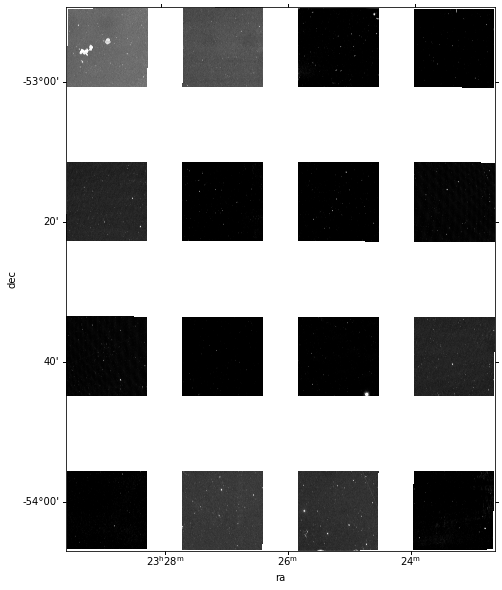

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot( projection=wcs_out1)
p2, p98 = np.percentile(f[1].data, (2, 98))
img_rescale = exposure.rescale_intensity(array1, in_range=(p2, p98))
ax.imshow(img_rescale, cmap= 'gray')
ax.set_ylabel('dec')
ax.set_xlabel('ra')

#ax.set_xlim(23, 22.1)
#ax.set_ylim(-5000.5, 18658.5)
plt.show()


ax.get_

# For loop of mosaics

In [3]:
directory = '/Users/mncavieres/Documents/2022-1/Investigacion/Test Data'
files = os.listdir(directory)
tile = [obs for obs in files if 'v20180602' in  obs]
tile_dir = ['/Users/mncavieres/Documents/2022-1/Investigacion/Test Data/'+t for t in tile]

In [24]:
hduls = []
for snap in tile_dir:
    with fits.open(snap, memmap=True) as f:
        hduls.append(f[1:17])

In [32]:
wcs_out1, shape_out = find_optimal_celestial_wcs(np.array(hduls).ravel()) 

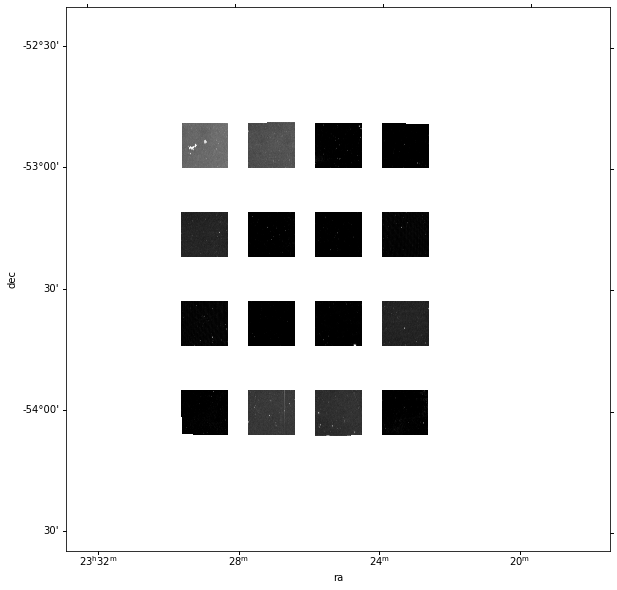

In [68]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot( projection=wcs_out1)
#p2, p98 = np.percentile(f[1].data, (2, 98))
#img_rescale = exposure.rescale_intensity(array, in_range=(p2, p98))
ax.imshow(img_rescale, cmap= 'gray')

ax.set_ylabel('dec')
ax.set_xlabel('ra')
ax.set_xlim(-5000.5, 18658.5)
ax.set_ylim(-5000.5, 18658.5)
plt.show()

In [88]:
f2 = fits.open(f'/Users/mncavieres/Documents/2022-1/Investigacion/Test Data/{tile[1]}', memmap=True)
wcs_out2, shape_out = find_optimal_celestial_wcs(f2[1:18]) 
array2, footprint = reproject_and_coadd(f2[1:18], wcs_out2, shape_out=shape_out, reproject_function=reproject_interp)

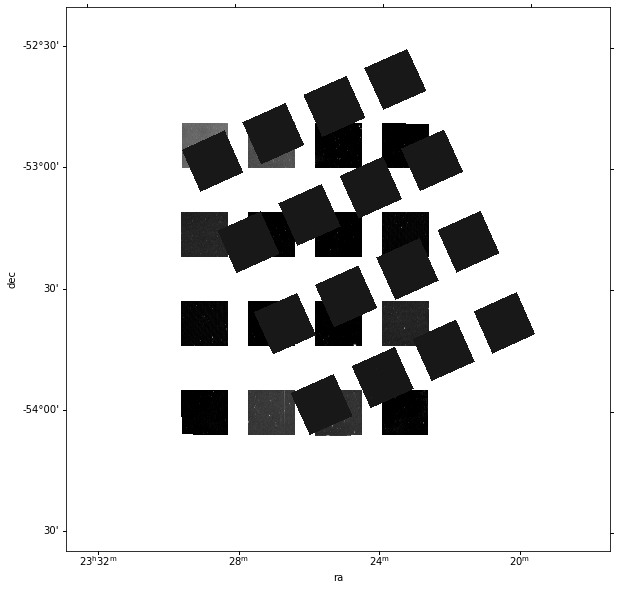

In [90]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot( projection=wcs_out1)
ax.imshow(img_rescale, cmap= 'gray')

#p2, p98 = np.percentile(f2[1].data, (2, 98))
#img_rescale1 = exposure.rescale_intensity(array2, in_range=(p2, p98))
ax.imshow(array2, cmap = 'gray')
ax.set_ylabel('dec')
ax.set_xlabel('ra')
ax.set_xlim(-5000.5, 18658.5)
ax.set_ylim(-5000.5, 18658.5)
plt.show()

In [73]:
for i in tqdm.tqdm(range(1000)):
    i+1

100%|██████████| 1000/1000 [00:00<00:00, 2826350.40it/s]


In [6]:
arrays = []
shape_outs = []
wscs = []
for t in tqdm.tqdm(tile):
    f2 = fits.open(f'/Users/mncavieres/Documents/2022-1/Investigacion/Test Data/{t}', memmap=True) #this will hold the file in memory
    wcs_out2, shape_out = find_optimal_celestial_wcs(f2[1:18]) 
    array2, footprint = reproject_and_coadd(f2[1:18], wcs_out2, shape_out=shape_out, reproject_function=reproject_interp)
    print(array2)
    arrays.append(array2)
    shape_outs.append(shape_out)
    wscs.append(wcs_out2)
    f2.close

  8%|▊         | 1/12 [01:17<14:16, 77.87s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 17%|█▋        | 2/12 [02:35<12:55, 77.60s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 25%|██▌       | 3/12 [03:52<11:35, 77.27s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 33%|███▎      | 4/12 [05:08<10:15, 76.99s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 42%|████▏     | 5/12 [06:25<08:58, 76.94s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 50%|█████     | 6/12 [07:42<07:42, 77.02s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 58%|█████▊    | 7/12 [14:07<14:47, 177.58s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 67%|██████▋   | 8/12 [15:24<09:42, 145.65s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 75%|███████▌  | 9/12 [16:41<06:12, 124.03s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 83%|████████▎ | 10/12 [17:59<03:39, 109.95s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 92%|█████████▏| 11/12 [19:17<01:40, 100.26s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


100%|██████████| 12/12 [20:34<00:00, 102.92s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [87]:
for t in tile[:3]:  
    f2 = fits.open(f'/Users/mncavieres/Documents/2022-1/Investigacion/Test Data/{t}', memmap=True)
    print(f2[0].header['DEC'])
    array2, footprint = reproject_and_coadd(f2[1:18], wcs_out2, shape_out=shape_out, reproject_function=reproject_interp)

-43.51382
-43.58914
-43.68067


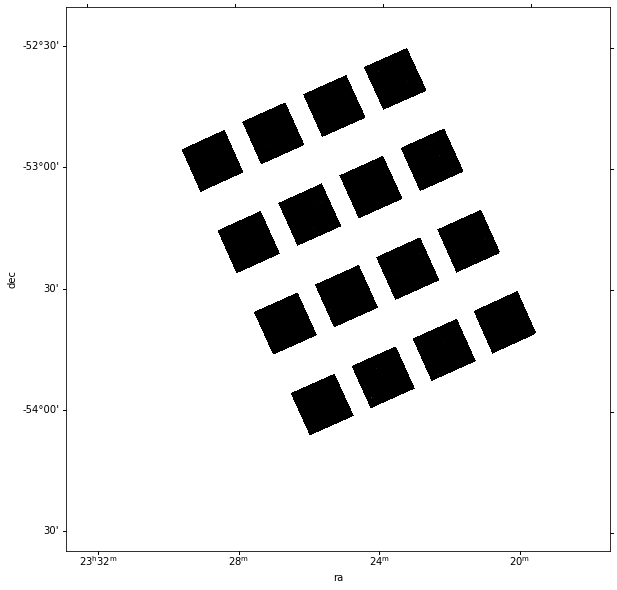

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot( projection=wcs_out1)
p2, p98 = np.percentile(f[1].data, (2, 98))
img_rescale = exposure.rescale_intensity(arrays[0], in_range=(p2, p98))
ax.imshow(img_rescale, cmap= 'gray')

for ar in arrays:
    img_rescale1 = exposure.rescale_intensity(ar, in_range=(p2, p98))
    ax.imshow(img_rescale1, cmap = 'gray')
ax.set_ylabel('dec')
ax.set_xlabel('ra')
ax.set_xlim(-5000.5, 18658.5)
ax.set_ylim(-5000.5, 18658.5)
plt.show()

# Mosc

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot( projection=wcs_out1)
p2, p98 = np.percentile(f[1].data, (2, 98))
img_rescale = exposure.rescale_intensity(arrays[0], in_range=(p2, p98))
ax.imshow(img_rescale, cmap= 'gray')

#img_rescale1 = exposure.rescale_intensity(arrays[1], in_range=(p2, p98))
ax.imshow(img_rescale1, cmap = 'gray')
ax.set_ylabel('dec')
ax.set_xlabel('ra')
ax.set_xlim(-5000.5, 18658.5)
ax.set_ylim(-5000.5, 18658.5)
plt.show()

: 

: 

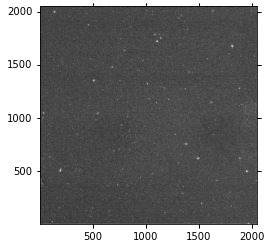

In [7]:
file_name= '/Users/mncavieres/Documents/2022-1/Investigacion/108149/prov/v20160909_00103.fit'




hdul = fits.open('/Users/mncavieres/Documents/2022-1/Investigacion/108149/prov/v20160909_00103.fit') #load single fits file
w = wcs.WCS(hdul[0].header, hdul)
fig = plt.figure()
ax = fig.add_subplot( projection=w)

p2, p98 = np.percentile(hdul[1].data, (2, 98))

img_rescale = exposure.rescale_intensity(hdul[1].data, in_range=(p2, p98))
ax.imshow(np.sinh(img_rescale), cmap= 'gray')

img_rescale2 = exposure.rescale_intensity(hdul[2].data, in_range=(p2, p98))
ax.imshow(np.sinh(img_rescale2), cmap= 'gray')
    #inhdr = hdul[i].header

    #chip_name = inhdr['EXTNAME']
    #print(f'chip:{chip_name}')



    #img_adapteq = exposure.equalize_adapthist(hdul[i].data, clip_limit=0.03

    
    

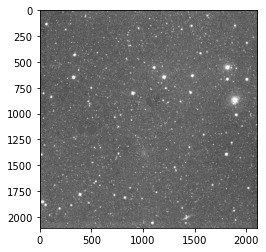

In [69]:
plt.imshow(np.sinh(img_rescale), cmap= 'gray')

In [53]:
inhdr = hdul[1].header
seeing = inhdr['seeing']
print(f'seeing is {seeing}')


seeing is 2.223106


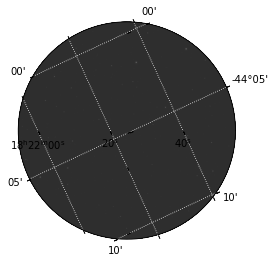

In [10]:
import matplotlib.pyplot as plt
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes.frame import EllipticalFrame

#image_file = get_pkg_data_filename('tutorials/FITS-images/HorseHead.fits')
#image_header = fits.open(image_file)[0].header  # extract header info
#image_data = fits.getdata(image_file, ext=0)

# use the WCS class to get coordinate info and projection axes to use
#wcs = WCS(image_header)

# make the axes using the EllipticalFrame class
ax = plt.subplot(projection=w, frame_class=EllipticalFrame)

# add the image
im = ax.imshow(hdul[1].data, origin='lower', cmap = 'gray')
for i in range(1, 16):
    im2 = ax.imshow(hdul[i].data, origin='lower', cmap = 'gray')
# add a grid
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')

In [2]:
import pandas as pd
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage import exposure
from astropy import wcs
import warnings
from astropy.coordinates import angular_separation
import seaborn as sns
import itertools
import astropy.units as u
import astropy.constants as c
import tqdm
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd 
import warnings
warnings.filterwarnings("ignore")

directory = '/Users/mncavieres/Documents/2022-1/Investigacion/Test Data'
files = os.listdir(directory)
tile = [obs for obs in files if 'v20180602' in  obs]
tile_dir = ['/Users/mncavieres/Documents/2022-1/Investigacion/Test Data/'+t for t in tile]

obs = tile[0]
print(f'working on: {obs}')
with fits.open(f'/Users/mncavieres/Documents/2022-1/Investigacion/Test Data/{obs}' ) as f2: #open fits
    wcs_out, shape_out = find_optimal_celestial_wcs(f2[1:18]) #get wcs object for mosaic
    array, footprint = reproject_and_coadd(f2[1:18], wcs_out, shape_out=shape_out, reproject_function=reproject_interp) #reproject and co add chips to build the mosaic
    


working on: v20180602_00085_st.fit


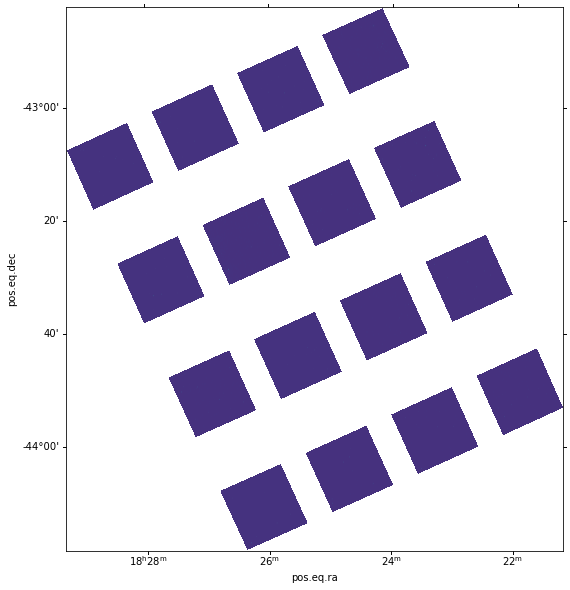

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot( projection=wcs_out)
ax.imshow(array, cmap = 'gray')

In [8]:
hdul = fits.PrimaryHDU(array, header= wcs_out.to_header())

hdul.writeto(f'{obs}_mosaic.fits')